# Import libraries

In [ ]:
# Import libraries
from zipfile import ZipFile
from google.colab import files
import os
import glob

import cv2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf 
import tensorflow_datasets as tfds
import keras
from keras import callbacks, optimizers, Model
from keras.utils import np_utils, to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, ReLU, Conv1D, MaxPooling1D, LSTM
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Nasdaq stock price prediction

## Load the data

In [ ]:
# # Upload the zip file to Colab
# uploaded = files.upload()

# # Extract the zip file to a folder
# with ZipFile('data_nasdaq_csv.zip', 'r') as zipObj:
#    # Extract all the contents to a folder named 'data'
#    zipObj.extractall('nasdaq-data')

In [ ]:
zip_file_path = '/content/drive/MyDrive/data_nasdaq_csv.zip'

# Extract the zip file to a folder
with ZipFile(zip_file_path, 'r') as zipObj:
   # Extract all the contents to a folder named 'data'
   zipObj.extractall('nasdaq-data')

In [ ]:
# Define the path to the directory containing the CSV files
path = '/content/nasdaq-data/csv'

# create an empty dictionary to store the data frames
df_dict = {}

# loop over the CSV files in the folder
for file_name in os.listdir(path):
    if file_name.endswith('.csv'):
        # read the CSV file into a data frame
        file_path = os.path.join(path, file_name)
        df = pd.read_csv(file_path, on_bad_lines='skip')
        
        # add a new column with the name of the CSV file
        df['Code'] = file_name.split('.')[0]
        
        # add the data frame to the dictionary
        df_dict[file_name] = df

# concatenate the data frames in the dictionary vertically
df = pd.concat(df_dict.values(), axis=0, ignore_index=True)

In [ ]:
# #set column names equal to values in row index position 0
# df.columns = df.iloc[0]

# #remove first row from DataFrame
# df = df[1:]

#reset index values
# df.reset_index(drop=True, inplace=True)

In [ ]:
df = df[df["Date"].str.contains("Date") == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8752323 entries, 0 to 8752322
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Date            object 
 1   Low             float64
 2   Open            float64
 3   Volume          float64
 4   High            float64
 5   Close           float64
 6   Adjusted Close  float64
 7   Code            object 
dtypes: float64(6), object(2)
memory usage: 601.0+ MB


## EDA

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.info()

<ipython-input-8-230e54c51c06>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8752323 entries, 0 to 8752322
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Date            datetime64[ns]
 1   Low             float64       
 2   Open            float64       
 3   Volume          float64       
 4   High            float64       
 5   Close           float64       
 6   Adjusted Close  float64       
 7   Code            object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 601.0+ MB


In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df

,Date,Low,Open,Volume,High,Close,Adjusted Close,Code
0,1991-08-30,2.916667,2.916667,723600.0,3.125000,3.083333,1.306808,MGIC
1,1991-03-09,2.791667,3.083333,506100.0,3.083333,2.833333,1.200851,MGIC
2,1991-04-09,2.791667,2.791667,398100.0,2.875000,2.833333,1.200851,MGIC
3,1991-05-09,2.750000,2.833333,453300.0,2.833333,2.791667,1.183192,MGIC
4,1991-06-09,2.708333,2.791667,117300.0,2.791667,2.708333,1.147872,MGIC
...,...,...,...,...,...,...,...,...
8752318,2022-06-12,39.070000,39.590000,1700.0,39.590000,39.070000,39.070000,TCFC
8752319,2022-07-12,39.490002,39.490002,1500.0,39.849998,39.849998,39.849998,TCFC
8752320,2022-08-12,39.660000,39.900002,2800.0,39.900002,39.799999,39.799999,TCFC
8752321,2022-09-12,39.590000,39.900002,1200.0,39.980000,39.980000,39.980000,TCFC


In [ ]:
df_covid = df[df['Date'].dt.year >= 2019]
df_covid

,Date,Low,Open,Volume,High,Close,Adjusted Close,Code
6886,2019-02-01,7.500000,7.510000,19300.0,7.730000,7.670000,7.306146,MGIC
6887,2019-03-01,7.310000,7.540000,25000.0,7.810000,7.680000,7.315671,MGIC
6888,2019-04-01,7.720000,7.830000,10900.0,7.940000,7.720000,7.353775,MGIC
6889,2019-07-01,7.640000,7.790000,9000.0,7.860000,7.800000,7.429979,MGIC
6890,2019-08-01,7.770000,8.000000,16500.0,8.050000,7.980000,7.601440,MGIC
...,...,...,...,...,...,...,...,...
8752318,2022-06-12,39.070000,39.590000,1700.0,39.590000,39.070000,39.070000,TCFC
8752319,2022-07-12,39.490002,39.490002,1500.0,39.849998,39.849998,39.849998,TCFC
8752320,2022-08-12,39.660000,39.900002,2800.0,39.900002,39.799999,39.799999,TCFC
8752321,2022-09-12,39.590000,39.900002,1200.0,39.980000,39.980000,39.980000,TCFC


In [ ]:
df_covid = df_covid[df_covid['Open']>1]
df_covid = df_covid[df_covid['Low']>1]
df_covid = df_covid[df_covid['Volume']>1]
df_covid = df_covid[df_covid['High']>1]
df_covid = df_covid[df_covid['Close']>1]
df_covid = df_covid[df_covid['Adjusted Close']>1]
df_covid

,Date,Low,Open,Volume,High,Close,Adjusted Close,Code
6886,2019-02-01,7.500000,7.510000,19300.0,7.730000,7.670000,7.306146,MGIC
6887,2019-03-01,7.310000,7.540000,25000.0,7.810000,7.680000,7.315671,MGIC
6888,2019-04-01,7.720000,7.830000,10900.0,7.940000,7.720000,7.353775,MGIC
6889,2019-07-01,7.640000,7.790000,9000.0,7.860000,7.800000,7.429979,MGIC
6890,2019-08-01,7.770000,8.000000,16500.0,8.050000,7.980000,7.601440,MGIC
...,...,...,...,...,...,...,...,...
8752318,2022-06-12,39.070000,39.590000,1700.0,39.590000,39.070000,39.070000,TCFC
8752319,2022-07-12,39.490002,39.490002,1500.0,39.849998,39.849998,39.849998,TCFC
8752320,2022-08-12,39.660000,39.900002,2800.0,39.900002,39.799999,39.799999,TCFC
8752321,2022-09-12,39.590000,39.900002,1200.0,39.980000,39.980000,39.980000,TCFC


In [ ]:
for company in df_covid['Code'].unique():
  if df_covid['Code'].tolist().count(company)<720:
    df_covid = df_covid[df_covid["Code"].str.contains(company) == False]
df_covid

,Date,Low,Open,Volume,High,Close,Adjusted Close,Code
6886,2019-02-01,7.500000,7.510000,19300.0,7.730000,7.670000,7.306146,MGIC
6887,2019-03-01,7.310000,7.540000,25000.0,7.810000,7.680000,7.315671,MGIC
6888,2019-04-01,7.720000,7.830000,10900.0,7.940000,7.720000,7.353775,MGIC
6889,2019-07-01,7.640000,7.790000,9000.0,7.860000,7.800000,7.429979,MGIC
6890,2019-08-01,7.770000,8.000000,16500.0,8.050000,7.980000,7.601440,MGIC
...,...,...,...,...,...,...,...,...
8752318,2022-06-12,39.070000,39.590000,1700.0,39.590000,39.070000,39.070000,TCFC
8752319,2022-07-12,39.490002,39.490002,1500.0,39.849998,39.849998,39.849998,TCFC
8752320,2022-08-12,39.660000,39.900002,2800.0,39.900002,39.799999,39.799999,TCFC
8752321,2022-09-12,39.590000,39.900002,1200.0,39.980000,39.980000,39.980000,TCFC


## Process the data

In [ ]:
X_data = []
y_data = []
window_size=120 # Time window for data feature (size of 'number of days').

# Only get the open price (index 2 in the data frame)
for i in range(1, len(df_covid) - window_size - 1):
    first = df_covid.iloc[i, 2]
    data_feature = []
    data_label = []
    
    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df_covid.iloc[i + j, 2])
        
    # Next value is the label (price of the next day) to be predicted
    data_label.append(df_covid.iloc[i + window_size, 2])
    
    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))

In [ ]:
### Split the data into training, validation and test set

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (513175, 120, 1)
Shape of validation set:  (128294, 120, 1)
Shape of test set:  (274916, 120, 1)


In [ ]:
# # Visualize the training, validation and test set
# df_plot = df['Open']
# df_plot = df_plot.reset_index(drop=False)

# # Get lengths of the three subsets
# size_train = X_train.shape[0]
# size_val = X_val.shape[0]
# size_test = X_test.shape[0]

# # Plot the subset splits
# ax = df_plot.iloc[:size_train,1:2].plot(y=0, color='red', label='Training set')
# df_plot.iloc[size_train:size_train+size_val,1:2].plot(y=0, color='blue', label='Validation set', ax=ax)
# df_plot.iloc[size_train+size_val:df_plot.shape[0],1:2].plot(y=0, color='green', label='Test set', ax=ax)
# ax.set_title("Stock trend")
# plt.xlabel('Time (days)')
# plt.ylabel('Open price in $')
# plt.axvline(x=size_train, color='black', linestyle='--')
# plt.axvline(x=size_train+size_val, color='black', linestyle='--')
# plt.show()

In [ ]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature = np.min(X_val[i])
    max_feature = np.max(X_val[i])
    X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

## Train the model

In [ ]:
### Create and train the model

# Build the model architecture
nasdaq = tf.keras.Sequential()
nasdaq.add(LSTM(units=64,activation='relu',return_sequences=True,input_shape=(window_size, 1)))
nasdaq.add(Dropout(0.2))
nasdaq.add(LSTM(units=64,return_sequences=True))
nasdaq.add(Dropout(0.2))
nasdaq.add(LSTM(units=64,return_sequences=True))
nasdaq.add(Dropout(0.2))
nasdaq.add(LSTM(units=64))
nasdaq.add(Dropout(0.2))
nasdaq.add(Dense(1))

nasdaq.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 120, 64)           16896     
                                                                 
 dropout_8 (Dropout)         (None, 120, 64)           0         
                                                                 
 lstm_9 (LSTM)               (None, 120, 64)           33024     
                                                                 
 dropout_9 (Dropout)         (None, 120, 64)           0         
                                                                 
 lstm_10 (LSTM)              (None, 120, 64)           33024     
                                                                 
 dropout_10 (Dropout)        (None, 120, 64)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)               

In [ ]:
# Compile and train the model with Mean Squared Error loss function
es = keras.callbacks.EarlyStopping(patience=10) # Early stopping condition
nasdaq.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'], )
nasdaq_history = nasdaq.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=2048, callbacks=[es])

Epoch 1/20
251/251 [==============================] - 64s 205ms/step - loss: 0.6937 - mse: 0.6937 - val_loss: 0.6352 - val_mse: 0.6352
Epoch 2/20
251/251 [==============================] - 49s 196ms/step - loss: 0.6743 - mse: 0.6743 - val_loss: 0.6342 - val_mse: 0.6342
Epoch 3/20
251/251 [==============================] - 49s 195ms/step - loss: 0.6735 - mse: 0.6735 - val_loss: 0.6335 - val_mse: 0.6335
Epoch 4/20
251/251 [==============================] - 49s 195ms/step - loss: 0.6729 - mse: 0.6729 - val_loss: 0.6339 - val_mse: 0.6339
Epoch 5/20
251/251 [==============================] - 49s 195ms/step - loss: 0.6727 - mse: 0.6727 - val_loss: 0.6340 - val_mse: 0.6340
Epoch 6/20
251/251 [==============================] - 49s 195ms/step - loss: 0.6724 - mse: 0.6724 - val_loss: 0.6329 - val_mse: 0.6329
Epoch 7/20
251/251 [==============================] - 48s 193ms/step - loss: 0.6719 - mse: 0.6719 - val_loss: 0.6336 - val_mse: 0.6336
Epoch 8/20
251/251 [==============================] - 5

## Test model performance and visualize the results

In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
# Get prediction on the test data
y_pred_norm = nasdaq.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

8592/8592 [==============================] - 185s 21ms/step
MSE on the test set:  0.43708452170635664


In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

# Vietnam stock price prediction

## Load the data

In [ ]:
zip_file_path = '/content/drive/MyDrive/data-vn-20230228.zip'

# Extract the zip file to a folder
with ZipFile(zip_file_path, 'r') as zipObj:
   # Extract all the contents to a folder named 'data'
   zipObj.extractall('vn-data')

In [ ]:
# Define the path to the directory containing the CSV files
path = '/content/vn-data/stock-historical-data'

# create an empty dictionary to store the data frames
df_dict = {}

# loop over the CSV files in the folder
for file_name in os.listdir(path):
    if file_name.endswith('.csv'):
        # read the CSV file into a data frame
        file_path = os.path.join(path, file_name)
        df = pd.read_csv(file_path, index_col=0, on_bad_lines='skip')
        
        # add a new column with the name of the CSV file
        code, group, _ = file_name.split('-')
        df['Code'] = code
        df['Group'] = group
        
        # check if minimum and maximum Open values are different
        df_dict[file_name] = df

# concatenate the data frames in the dictionary vertically
df = pd.concat(df_dict.values(), axis=0, ignore_index=True)

In [ ]:
df

,Open,High,Low,Close,Volume,TradingDate,Code,Group
0,5672.0,6318.0,5290.0,5819.0,1828600.0,2009-06-25,SHS,HNXIndex
1,6098.0,6171.0,5848.0,5922.0,1163400.0,2009-06-26,SHS,HNXIndex
2,5936.0,6157.0,5848.0,5951.0,1534300.0,2009-06-29,SHS,HNXIndex
3,5951.0,5980.0,5539.0,5760.0,867200.0,2009-06-30,SHS,HNXIndex
4,5363.0,5407.0,5363.0,5363.0,1488400.0,2009-07-01,SHS,HNXIndex
...,...,...,...,...,...,...,...,...
3719436,27500.0,27500.0,27500.0,27500.0,400.0,2023-02-22,DTL,VNINDEX
3719437,27500.0,27500.0,27400.0,27400.0,300.0,2023-02-23,DTL,VNINDEX
3719438,27400.0,27400.0,27400.0,27400.0,300.0,2023-02-24,DTL,VNINDEX
3719439,27400.0,27400.0,27300.0,27300.0,900.0,2023-02-27,DTL,VNINDEX


In [ ]:
df = df[df["TradingDate"].str.contains("TradingDate") == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3719441 entries, 0 to 3719440
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Open         float64
 1   High         float64
 2   Low          float64
 3   Close        float64
 4   Volume       float64
 5   TradingDate  object 
 6   Code         object 
 7   Group        object 
dtypes: float64(5), object(3)
memory usage: 255.4+ MB


## EDA

In [ ]:
df['TradingDate'] = pd.to_datetime(df['TradingDate'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3719441 entries, 0 to 3719440
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Open         float64       
 1   High         float64       
 2   Low          float64       
 3   Close        float64       
 4   Volume       float64       
 5   TradingDate  datetime64[ns]
 6   Code         object        
 7   Group        object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 255.4+ MB


In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3717729 entries, 0 to 3719440
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Open         float64       
 1   High         float64       
 2   Low          float64       
 3   Close        float64       
 4   Volume       float64       
 5   TradingDate  datetime64[ns]
 6   Code         object        
 7   Group        object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 255.3+ MB


In [ ]:
df_covid = df[df['TradingDate'].dt.year >= 2019]
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1593783 entries, 2379 to 3719440
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Open         1593783 non-null  float64       
 1   High         1593783 non-null  float64       
 2   Low          1593783 non-null  float64       
 3   Close        1593783 non-null  float64       
 4   Volume       1593783 non-null  float64       
 5   TradingDate  1593783 non-null  datetime64[ns]
 6   Code         1593783 non-null  object        
 7   Group        1593783 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 109.4+ MB


In [ ]:
df_covid = df_covid[df_covid['Open']>1]
df_covid = df_covid[df_covid['Low']>1]
df_covid = df_covid[df_covid['Volume']>1]
df_covid = df_covid[df_covid['High']>1]
df_covid = df_covid[df_covid['Close']>1]


df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947544 entries, 2379 to 3719440
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Open         947544 non-null  float64       
 1   High         947544 non-null  float64       
 2   Low          947544 non-null  float64       
 3   Close        947544 non-null  float64       
 4   Volume       947544 non-null  float64       
 5   TradingDate  947544 non-null  datetime64[ns]
 6   Code         947544 non-null  object        
 7   Group        947544 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 65.1+ MB


In [ ]:
for company in df_covid['Code'].unique():
  if df_covid['Code'].tolist().count(company)<720:
    df_covid = df_covid[df_covid["Code"].str.contains(company) == False]
df_covid

,Open,High,Low,Close,Volume,TradingDate,Code,Group
2379,3347.0,3290.0,3214.0,3269.0,695390.0,2019-01-02,SHS,HNXIndex
2380,3269.0,3262.0,3159.0,3191.0,538218.0,2019-01-03,SHS,HNXIndex
2381,3165.0,3236.0,3131.0,3191.0,376220.0,2019-01-04,SHS,HNXIndex
2382,3217.0,3227.0,3176.0,3217.0,303750.0,2019-01-07,SHS,HNXIndex
2383,3217.0,3250.0,3198.0,3217.0,427940.0,2019-01-08,SHS,HNXIndex
...,...,...,...,...,...,...,...,...
3719436,27500.0,27500.0,27500.0,27500.0,400.0,2023-02-22,DTL,VNINDEX
3719437,27500.0,27500.0,27400.0,27400.0,300.0,2023-02-23,DTL,VNINDEX
3719438,27400.0,27400.0,27400.0,27400.0,300.0,2023-02-24,DTL,VNINDEX
3719439,27400.0,27400.0,27300.0,27300.0,900.0,2023-02-27,DTL,VNINDEX


In [ ]:
df_covid['Group'].unique()

array(['HNXIndex', 'VNINDEX', 'UpcomIndex'], dtype=object)

## HNXIndex

In [ ]:
df_hnx = df_covid[df_covid['Group'] == 'HNXIndex']
df_hnx

,Open,High,Low,Close,Volume,TradingDate,Code,Group
2379,3347.0,3290.0,3214.0,3269.0,695390.0,2019-01-02,SHS,HNXIndex
2380,3269.0,3262.0,3159.0,3191.0,538218.0,2019-01-03,SHS,HNXIndex
2381,3165.0,3236.0,3131.0,3191.0,376220.0,2019-01-04,SHS,HNXIndex
2382,3217.0,3227.0,3176.0,3217.0,303750.0,2019-01-07,SHS,HNXIndex
2383,3217.0,3250.0,3198.0,3217.0,427940.0,2019-01-08,SHS,HNXIndex
...,...,...,...,...,...,...,...,...
3702652,32000.0,32200.0,32000.0,32100.0,96500.0,2023-02-22,GKM,HNXIndex
3702653,32100.0,32300.0,31300.0,32100.0,34600.0,2023-02-23,GKM,HNXIndex
3702654,32100.0,32100.0,31500.0,32100.0,180400.0,2023-02-24,GKM,HNXIndex
3702655,32200.0,32200.0,31900.0,32200.0,101506.0,2023-02-27,GKM,HNXIndex


### Process the data

In [ ]:
X_data = []
y_data = []
window_size=7 # Time window for data feature (size of 'number of days').

# Only get the open price (index 2 in the data frame)
for i in range(1, len(df_hnx) - window_size - 1):
    first = df_hnx.iloc[i, 2]
    data_feature = []
    data_label = []
    
    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df_hnx.iloc[i + j, 2])
        
    # Next value is the label (price of the next day) to be predicted
    data_label.append(df_hnx.iloc[i + window_size, 2])
    
    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))

In [ ]:
### Split the data into training, validation and test set

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (86233, 120, 1)
Shape of validation set:  (21559, 120, 1)
Shape of test set:  (46197, 120, 1)


In [ ]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature = np.min(X_val[i])
    max_feature = np.max(X_val[i])
    X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

### Train the model

In [ ]:
### Create and train the model

# Build the model architecture
hnx = tf.keras.Sequential()
hnx.add(LSTM(units=64,activation='relu',return_sequences=True,input_shape=(window_size, 1)))
hnx.add(Dropout(0.2))
hnx.add(LSTM(units=64,return_sequences=True))
hnx.add(Dropout(0.2))
hnx.add(LSTM(units=64,return_sequences=True))
hnx.add(Dropout(0.2))
hnx.add(LSTM(units=64))
hnx.add(Dropout(0.2))
hnx.add(Dense(1))

hnx.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 120, 64)           16896     
                                                                 
 dropout_4 (Dropout)         (None, 120, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 120, 64)           33024     
                                                                 
 dropout_5 (Dropout)         (None, 120, 64)           0         
                                                                 
 lstm_6 (LSTM)               (None, 120, 64)           33024     
                                                                 
 dropout_6 (Dropout)         (None, 120, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)               

In [ ]:
# Compile and train the model with Mean Squared Error loss function
es = keras.callbacks.EarlyStopping(patience=10) # Early stopping condition
hnx.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'], )
hnx_history = hnx.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=2048, callbacks=[es])

Epoch 1/20
43/43 [==============================] - 23s 279ms/step - loss: 0.0836 - mse: 0.0836 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 2/20
43/43 [==============================] - 11s 251ms/step - loss: 0.0260 - mse: 0.0260 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 3/20
43/43 [==============================] - 11s 251ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 4/20
43/43 [==============================] - 11s 252ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 5/20
43/43 [==============================] - 11s 246ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0169 - val_mse: 0.0169
Epoch 6/20
43/43 [==============================] - 11s 248ms/step - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 7/20
43/43 [==============================] - 11s 249ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 8/20
43/43 [==============================] - 11s 250ms/step - 

### Test model performance and visualize the results

In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
# Get prediction on the test data
y_pred_norm = hnx.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

1444/1444 [==============================] - 33s 22ms/step
MSE on the test set:  0.02034564843557675


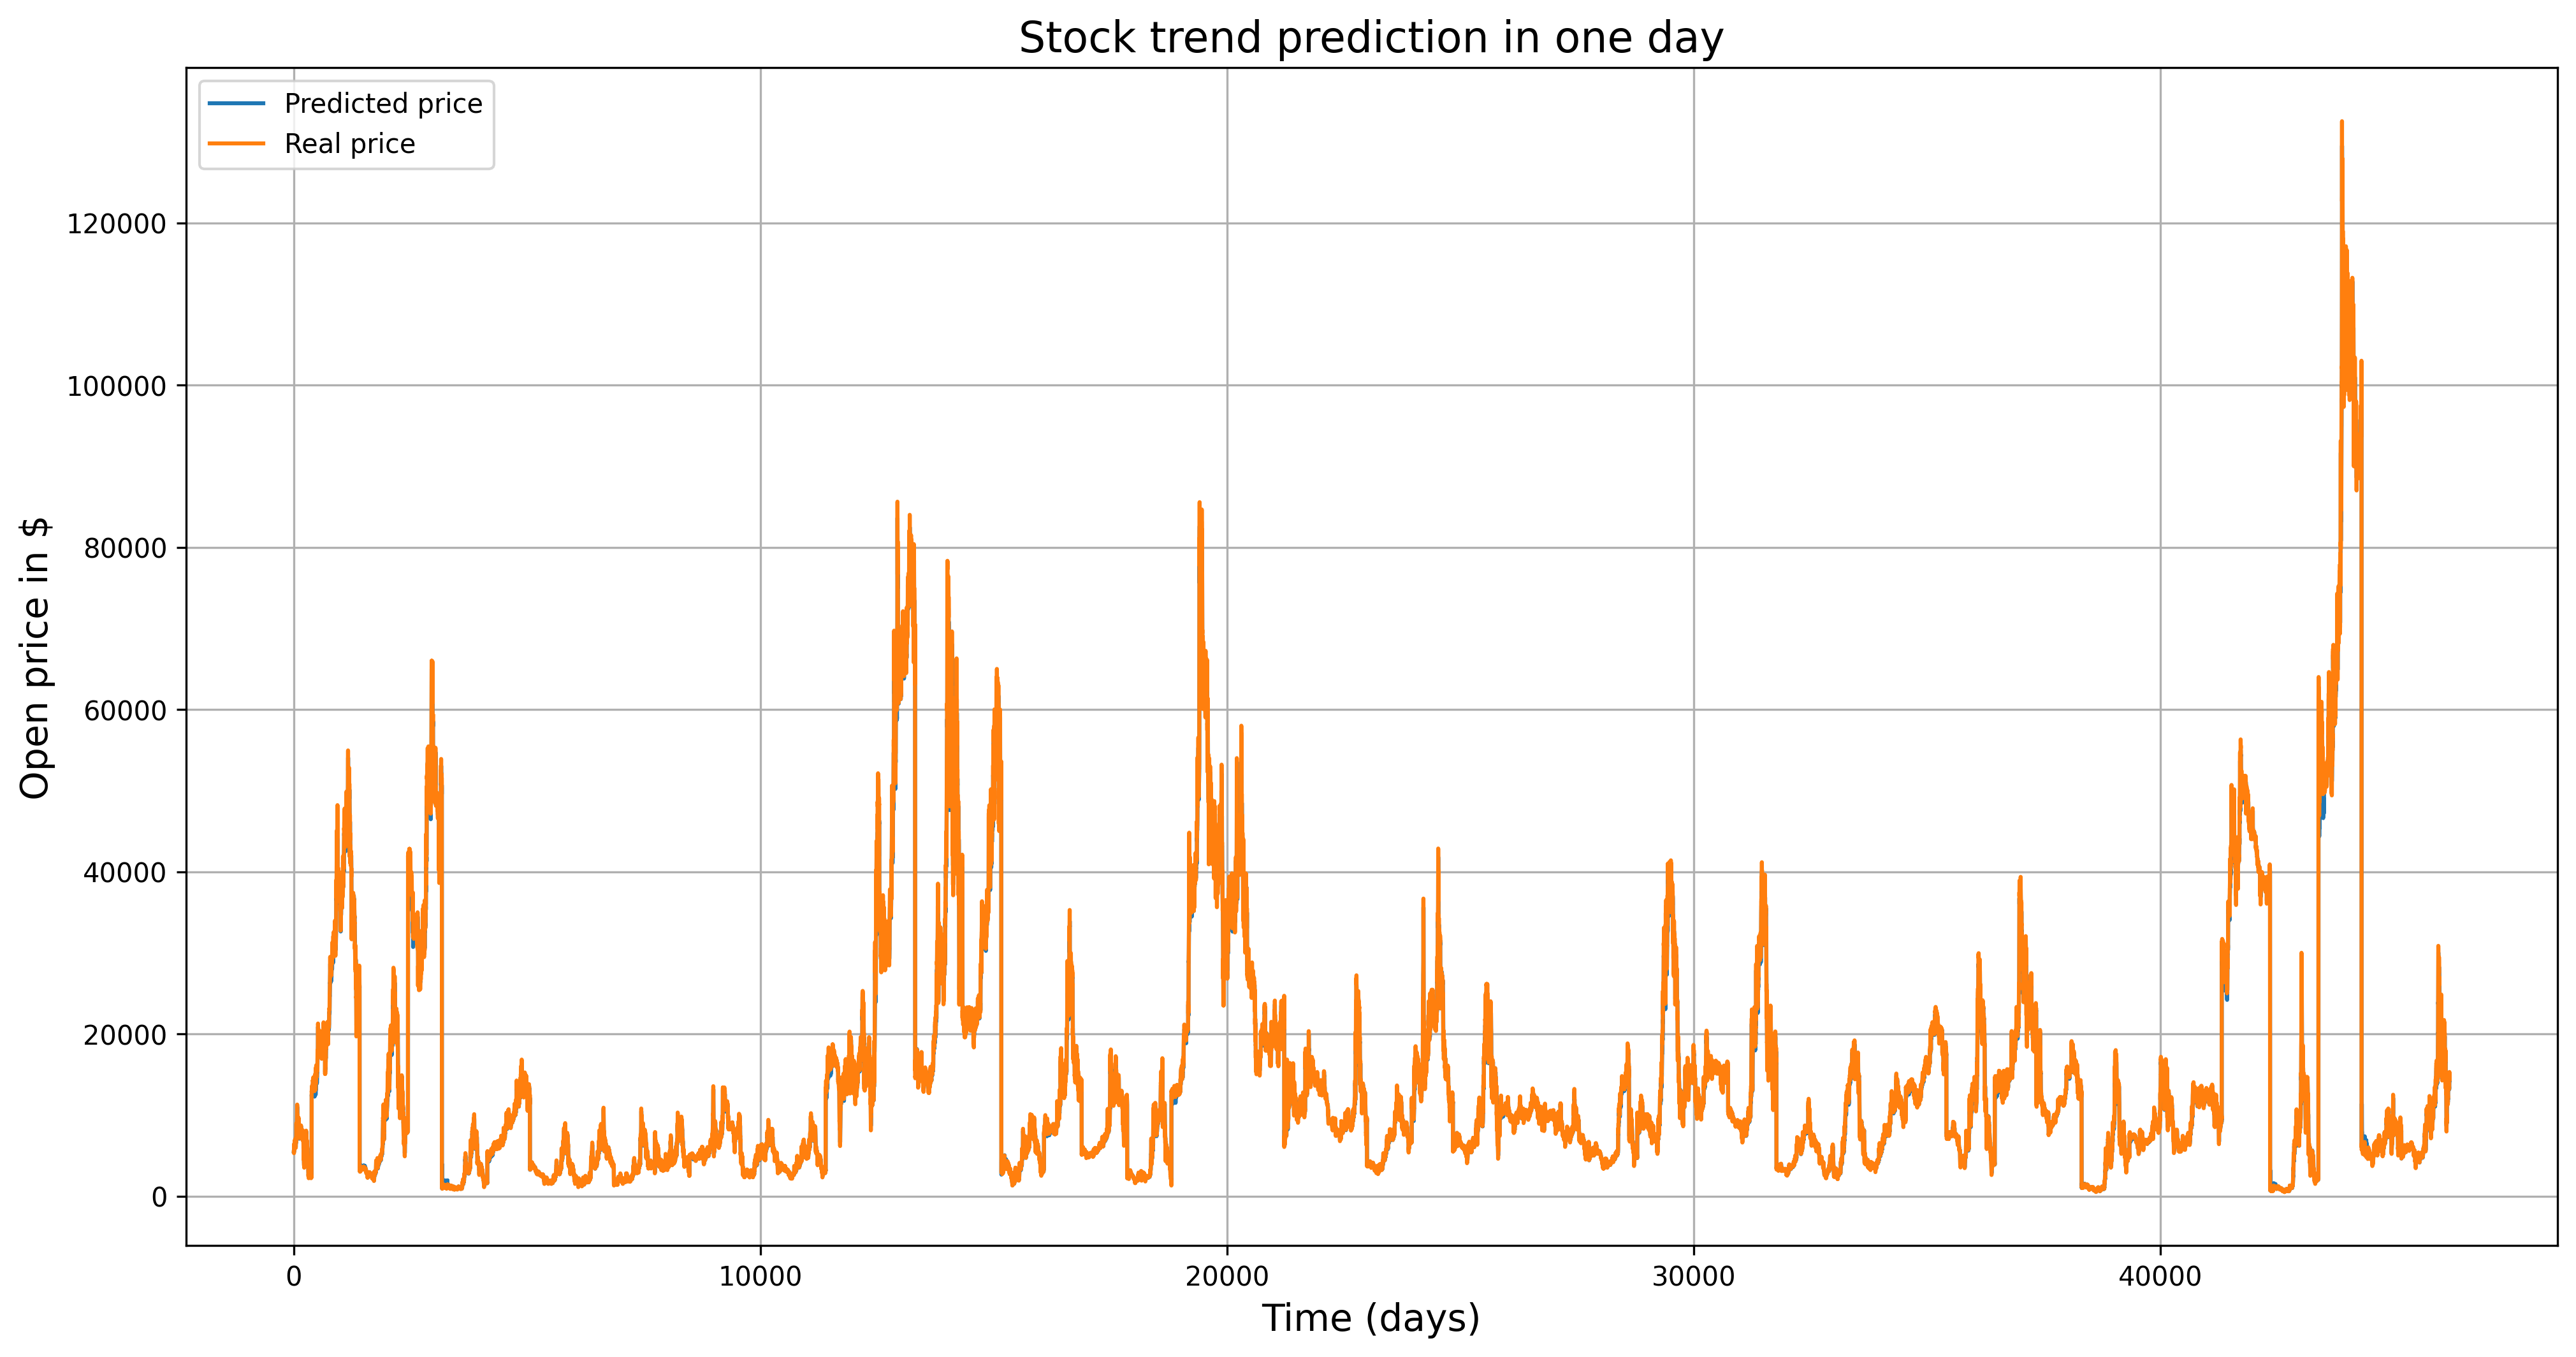

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

## UpcomIndex

In [ ]:
df_upcom = df_covid[df_covid['Group'] == 'UpcomIndex']
df_upcom

,Open,High,Low,Close,Volume,TradingDate,Code,Group
53980,600.0,600.0,500.0,600.0,76200.0,2019-01-02,PVV,UpcomIndex
53981,600.0,600.0,500.0,500.0,14200.0,2019-01-03,PVV,UpcomIndex
53982,600.0,600.0,400.0,400.0,175800.0,2019-01-04,PVV,UpcomIndex
53983,500.0,500.0,400.0,500.0,46700.0,2019-01-07,PVV,UpcomIndex
53984,600.0,600.0,500.0,500.0,84500.0,2019-01-08,PVV,UpcomIndex
...,...,...,...,...,...,...,...,...
3665549,8700.0,8700.0,8700.0,8700.0,400.0,2023-02-16,BBT,UpcomIndex
3665550,8700.0,8700.0,8700.0,8700.0,100.0,2023-02-17,BBT,UpcomIndex
3665551,9000.0,9000.0,9000.0,9000.0,201.0,2023-02-20,BBT,UpcomIndex
3665554,9700.0,9700.0,9700.0,9700.0,100.0,2023-02-23,BBT,UpcomIndex


### Process the data

In [ ]:
X_data = []
y_data = []
window_size=7 # Time window for data feature (size of 'number of days').

# Only get the open price (index 2 in the data frame)
for i in range(1, len(df_upcom) - window_size - 1):
    first = df_upcom.iloc[i, 2]
    data_feature = []
    data_label = []
    
    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df_upcom.iloc[i + j, 2])
        
    # Next value is the label (price of the next day) to be predicted
    data_label.append(df_upcom.iloc[i + window_size, 2])
    
    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))

In [ ]:
### Split the data into training, validation and test set

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (79131, 7, 1)
Shape of validation set:  (19783, 7, 1)
Shape of test set:  (42393, 7, 1)


In [ ]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature = np.min(X_val[i])
    max_feature = np.max(X_val[i])
    X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

### Train the model

In [ ]:
### Create and train the model

# Build the model architecture
upcom = tf.keras.Sequential()
upcom.add(LSTM(units=64,activation='relu',return_sequences=True,input_shape=(window_size, 1)))
upcom.add(Dropout(0.2))
upcom.add(LSTM(units=64,return_sequences=True))
upcom.add(Dropout(0.2))
upcom.add(LSTM(units=64,return_sequences=True))
upcom.add(Dropout(0.2))
upcom.add(LSTM(units=64))
upcom.add(Dropout(0.2))
upcom.add(Dense(1))

upcom.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 120, 64)           16896     
                                                                 
 dropout_8 (Dropout)         (None, 120, 64)           0         
                                                                 
 lstm_9 (LSTM)               (None, 120, 64)           33024     
                                                                 
 dropout_9 (Dropout)         (None, 120, 64)           0         
                                                                 
 lstm_10 (LSTM)              (None, 120, 64)           33024     
                                                                 
 dropout_10 (Dropout)        (None, 120, 64)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)               

In [ ]:
# Compile and train the model with Mean Squared Error loss function
es = keras.callbacks.EarlyStopping(patience=10) # Early stopping condition
upcom.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'], )
upcom_history = upcom.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=2048, callbacks=[es])

Epoch 1/20
39/39 [==============================] - 17s 277ms/step - loss: 0.1122 - mse: 0.1122 - val_loss: 0.0429 - val_mse: 0.0429
Epoch 2/20
39/39 [==============================] - 10s 248ms/step - loss: 0.0376 - mse: 0.0376 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 3/20
39/39 [==============================] - 9s 243ms/step - loss: 0.0330 - mse: 0.0330 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 4/20
39/39 [==============================] - 10s 247ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 5/20
39/39 [==============================] - 10s 250ms/step - loss: 0.0289 - mse: 0.0289 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 6/20
39/39 [==============================] - 10s 250ms/step - loss: 0.0276 - mse: 0.0276 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 7/20
39/39 [==============================] - 10s 246ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0280 - val_mse: 0.0280
Epoch 8/20
39/39 [==============================] - 10s 250ms/step - l

### Test model performance and visualize the results

In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature)

In [ ]:
# Get prediction on the test data
y_pred_norm = hnx.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

1324/1324 [==============================] - 29s 22ms/step
MSE on the test set:  0.02631521196608248


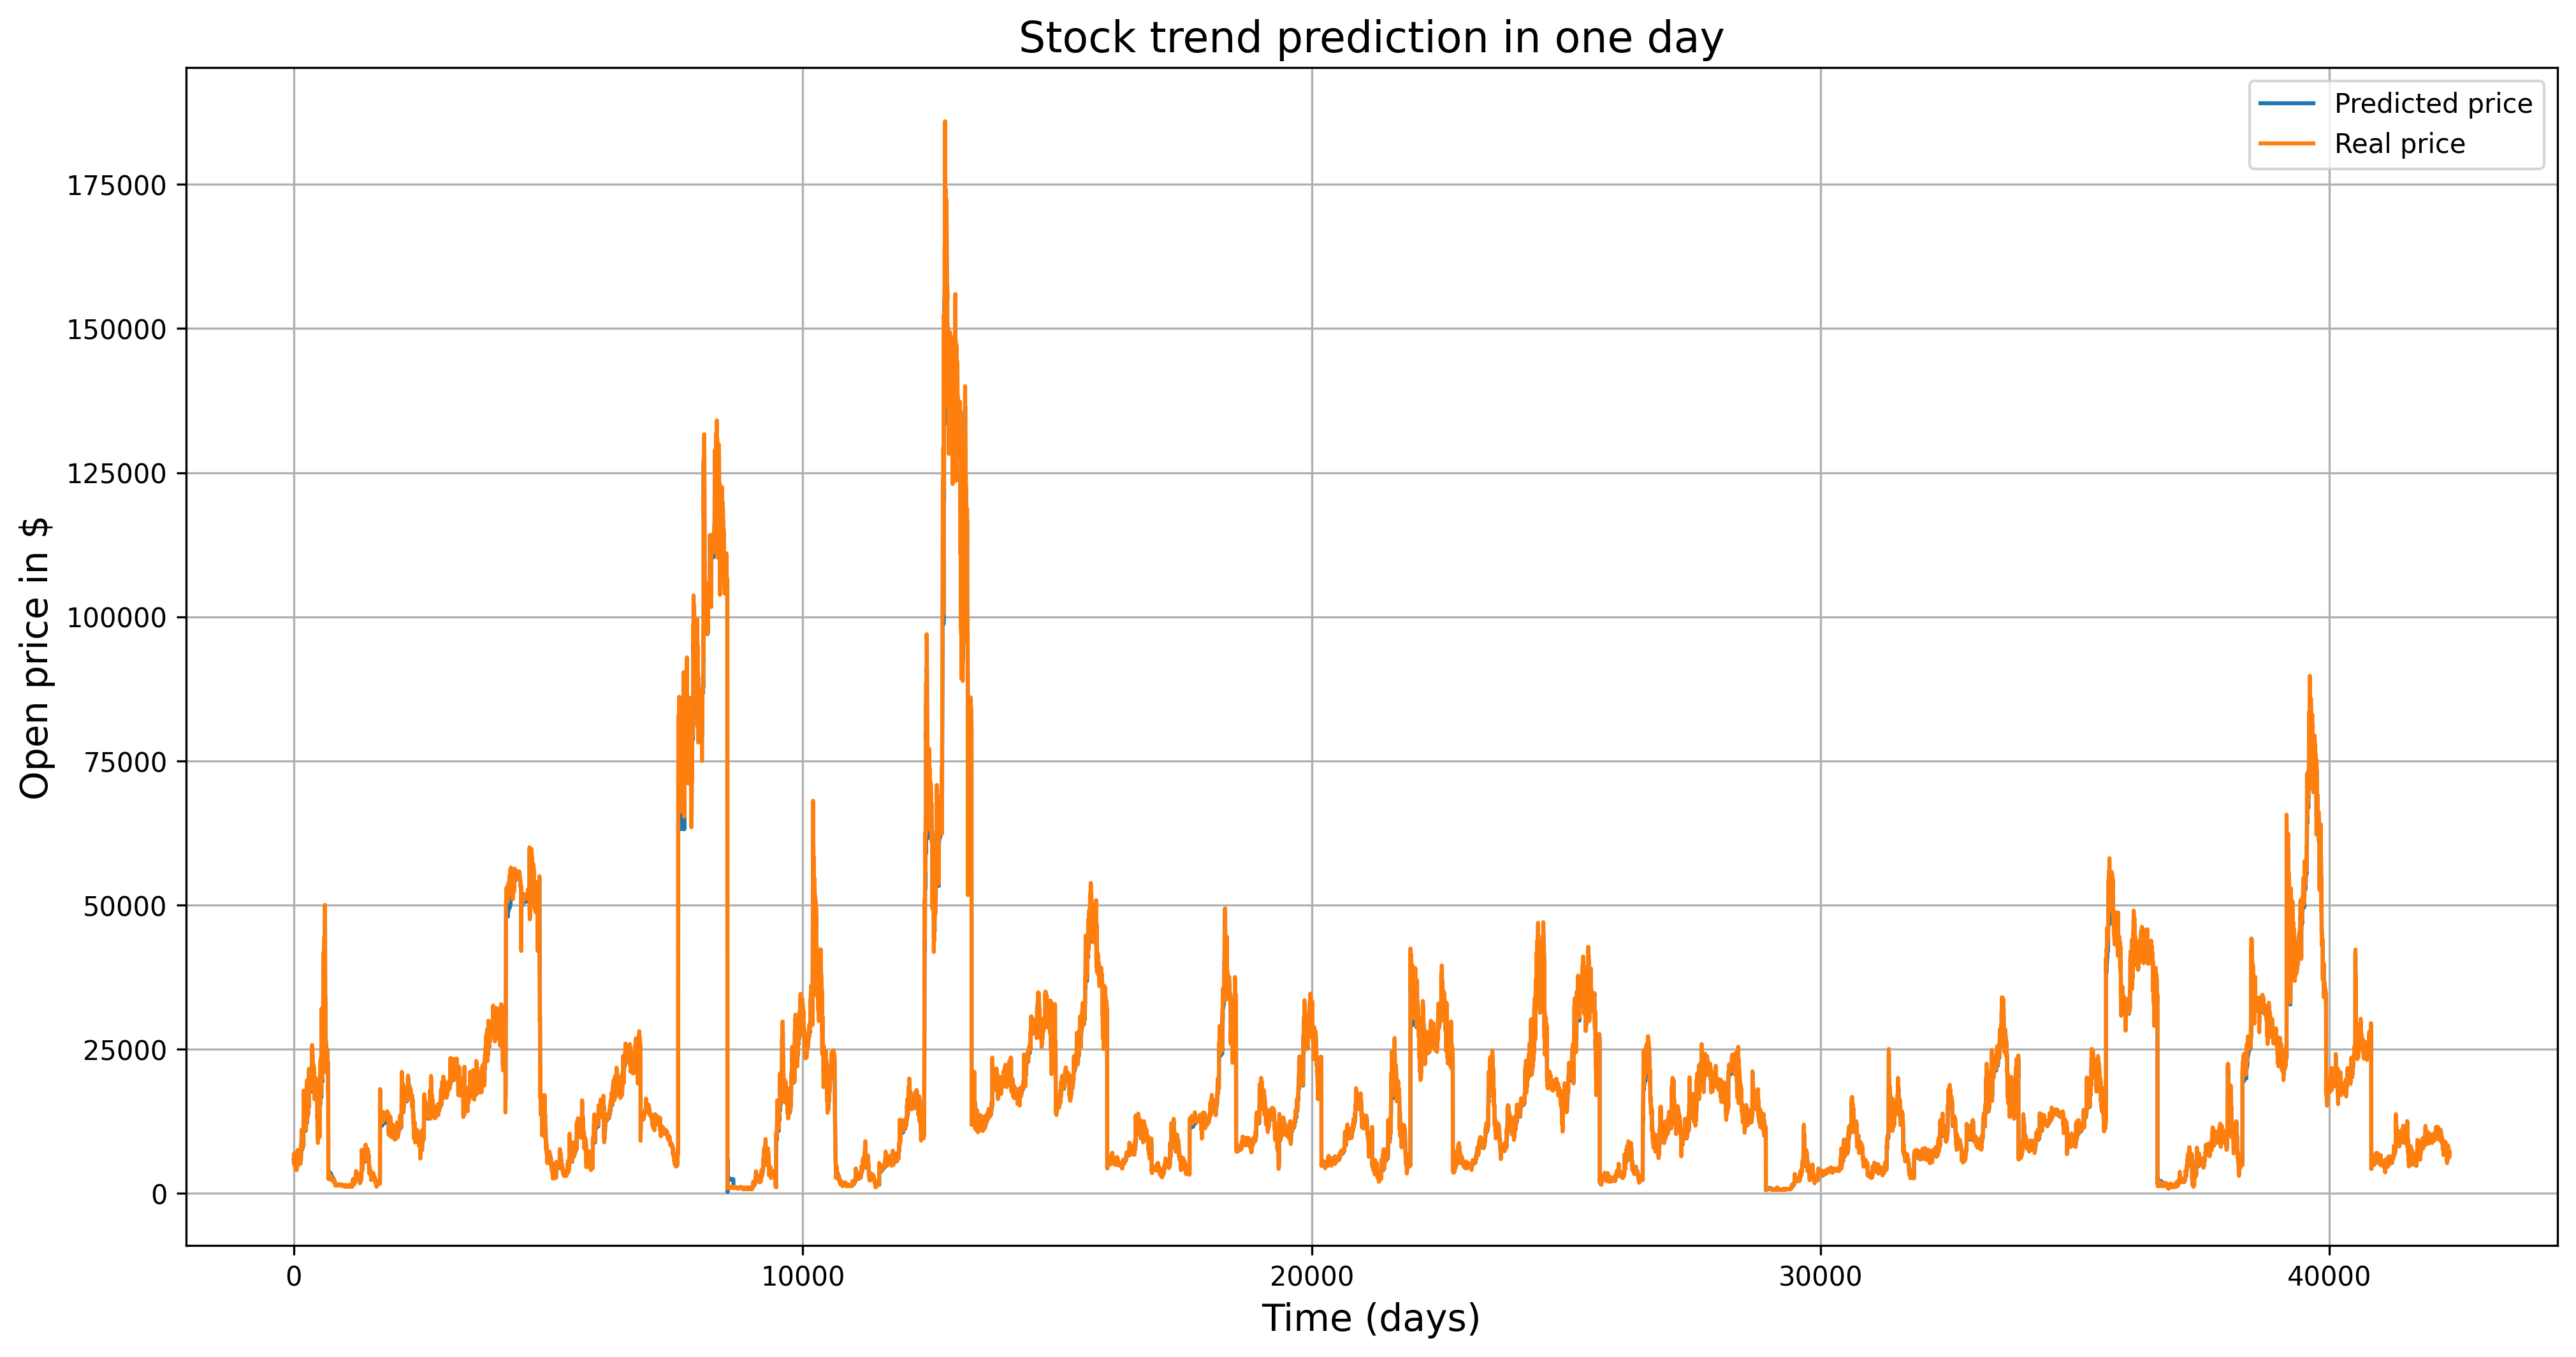

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()

## VNIndex

In [ ]:
df_vni = df_covid[df_covid['Group'] == 'VNINDEX']
df_vni

,Open,High,Low,Close,Volume,TradingDate,Code,Group
32030,11670.0,11961.0,11647.0,11961.0,7390.0,2019-01-02,SFI,VNINDEX
32031,12364.0,12364.0,12364.0,12364.0,410.0,2019-01-03,SFI,VNINDEX
32032,11692.0,12006.0,11692.0,12006.0,2030.0,2019-01-04,SFI,VNINDEX
32033,11423.0,11961.0,11423.0,11871.0,100.0,2019-01-07,SFI,VNINDEX
32034,12185.0,12185.0,12185.0,12185.0,110.0,2019-01-08,SFI,VNINDEX
...,...,...,...,...,...,...,...,...
3709362,14800.0,15000.0,14700.0,14750.0,93085.0,2023-02-22,PPC,VNINDEX
3709363,14900.0,15000.0,14700.0,14750.0,70363.0,2023-02-23,PPC,VNINDEX
3709364,14800.0,14950.0,14700.0,14700.0,30680.0,2023-02-24,PPC,VNINDEX
3709365,14700.0,14850.0,14600.0,14700.0,65307.0,2023-02-27,PPC,VNINDEX


### Process the data

In [ ]:
X_data = []
y_data = []
window_size=14 # Time window for data feature (size of 'number of days').

# Only get the open price (index 2 in the data frame)
for i in range(1, len(df_vni) - window_size - 1):
    first = df_vni.iloc[i, 2]
    data_feature = []
    data_label = []
    
    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df_vni.iloc[i + j, 2])
        
    # Next value is the label (price of the next day) to be predicted
    data_label.append(df_vni.iloc[i + window_size, 2])
    
    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))

In [ ]:
### Split the data into training, validation and test set

# Split data into train, val and test. Note that 'shuffle=False' due to time-series data.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Convert from lists to Numpy arrays for reshaping purpose
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Reshape the numpy array to fit the neural network input shape requirement
X_train = X_train.reshape(X_train.shape[0], window_size, 1)
X_val = X_val.reshape(X_val.shape[0], window_size, 1)
X_test = X_test.reshape(X_test.shape[0], window_size, 1)

# Print shape of the training, validation and test set
print("Shape of training set: ", X_train.shape)
print("Shape of validation set: ", X_val.shape)
print("Shape of test set: ", X_test.shape)

Shape of training set:  (204086, 14, 1)
Shape of validation set:  (51022, 14, 1)
Shape of test set:  (109332, 14, 1)


In [ ]:
# MinMax normalize the training data: x=(x-min(x)/(max(x)-min(x))
X_train_norm = X_train.copy()
y_train_norm = y_train.copy()
for i in range(0, len(X_train)):
    min_feature = np.min(X_train[i])
    max_feature = np.max(X_train[i])
    X_train_norm[i] = (X_train[i] - min_feature) / (max_feature - min_feature)
    y_train_norm[i] = (y_train[i] - min_feature) / (max_feature - min_feature)

# MinMax normalize the validation data: x=(x-min(x)/(max(x)-min(x))
X_val_norm = X_val.copy()
y_val_norm = y_val.copy()
for i in range(0, len(X_val)):
    min_feature = np.min(X_val[i])
    max_feature = np.max(X_val[i])
    X_val_norm[i] = (X_val[i] - min_feature) / (max_feature - min_feature)
    y_val_norm[i] = (y_val[i] - min_feature) / (max_feature - min_feature)

### Train the model

In [ ]:
### Create and train the model

# Build the model architecture
vni = tf.keras.Sequential()
vni.add(LSTM(units=64,activation='relu',return_sequences=True,input_shape=(window_size, 1)))
vni.add(Dropout(0.2))
vni.add(LSTM(units=64,return_sequences=True))
vni.add(Dropout(0.2))
vni.add(LSTM(units=64,return_sequences=True))
vni.add(Dropout(0.2))
vni.add(LSTM(units=64))
vni.add(Dropout(0.2))
vni.add(Dense(1))

vni.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 14, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 14, 64)            33024     
                                                                 
 dropout_2 (Dropout)         (None, 14, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                3

In [ ]:
# Compile and train the model with Mean Squared Error loss function
es = keras.callbacks.EarlyStopping(patience=10) # Early stopping condition
vni.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse', metrics=['mse'], )
vni_history = vni.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=30, batch_size=1024, callbacks=[es])

Epoch 1/30
200/200 [==============================] - 17s 33ms/step - loss: 1.4023 - mse: 1.4023 - val_loss: 1.1979 - val_mse: 1.1979
Epoch 2/30
200/200 [==============================] - 5s 25ms/step - loss: 1.3542 - mse: 1.3542 - val_loss: 1.1917 - val_mse: 1.1917
Epoch 3/30
200/200 [==============================] - 5s 25ms/step - loss: 1.3490 - mse: 1.3490 - val_loss: 1.1911 - val_mse: 1.1911
Epoch 4/30
200/200 [==============================] - 6s 28ms/step - loss: 1.3485 - mse: 1.3485 - val_loss: 1.1915 - val_mse: 1.1915
Epoch 5/30
200/200 [==============================] - 5s 26ms/step - loss: 1.3478 - mse: 1.3478 - val_loss: 1.1909 - val_mse: 1.1909
Epoch 6/30
200/200 [==============================] - 5s 27ms/step - loss: 1.3466 - mse: 1.3466 - val_loss: 1.1995 - val_mse: 1.1995
Epoch 7/30
200/200 [==============================] - 5s 26ms/step - loss: 1.3471 - mse: 1.3471 - val_loss: 1.1904 - val_mse: 1.1904
Epoch 8/30
200/200 [==============================] - 5s 25ms/step -

### Test model performance and visualize the results

In [ ]:
# MinMax normalize the test data: norm_x = (x-min(x) / (max(x) - min(x))
X_test_norm = X_test.copy()
y_test_norm = y_test.copy()
for i in range(0, len(X_test)):
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    # Check if denominator is zero
    X_test_norm[i] = (X_test[i] - min_feature) / (max_feature - min_feature)
    y_test_norm[i] = (y_test[i] - min_feature) / (max_feature - min_feature) 

In [ ]:
# Get prediction on the test data
y_pred_norm = vni.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

3417/3417 [==============================] - 17s 5ms/step
MSE on the test set:  0.8719100434956525


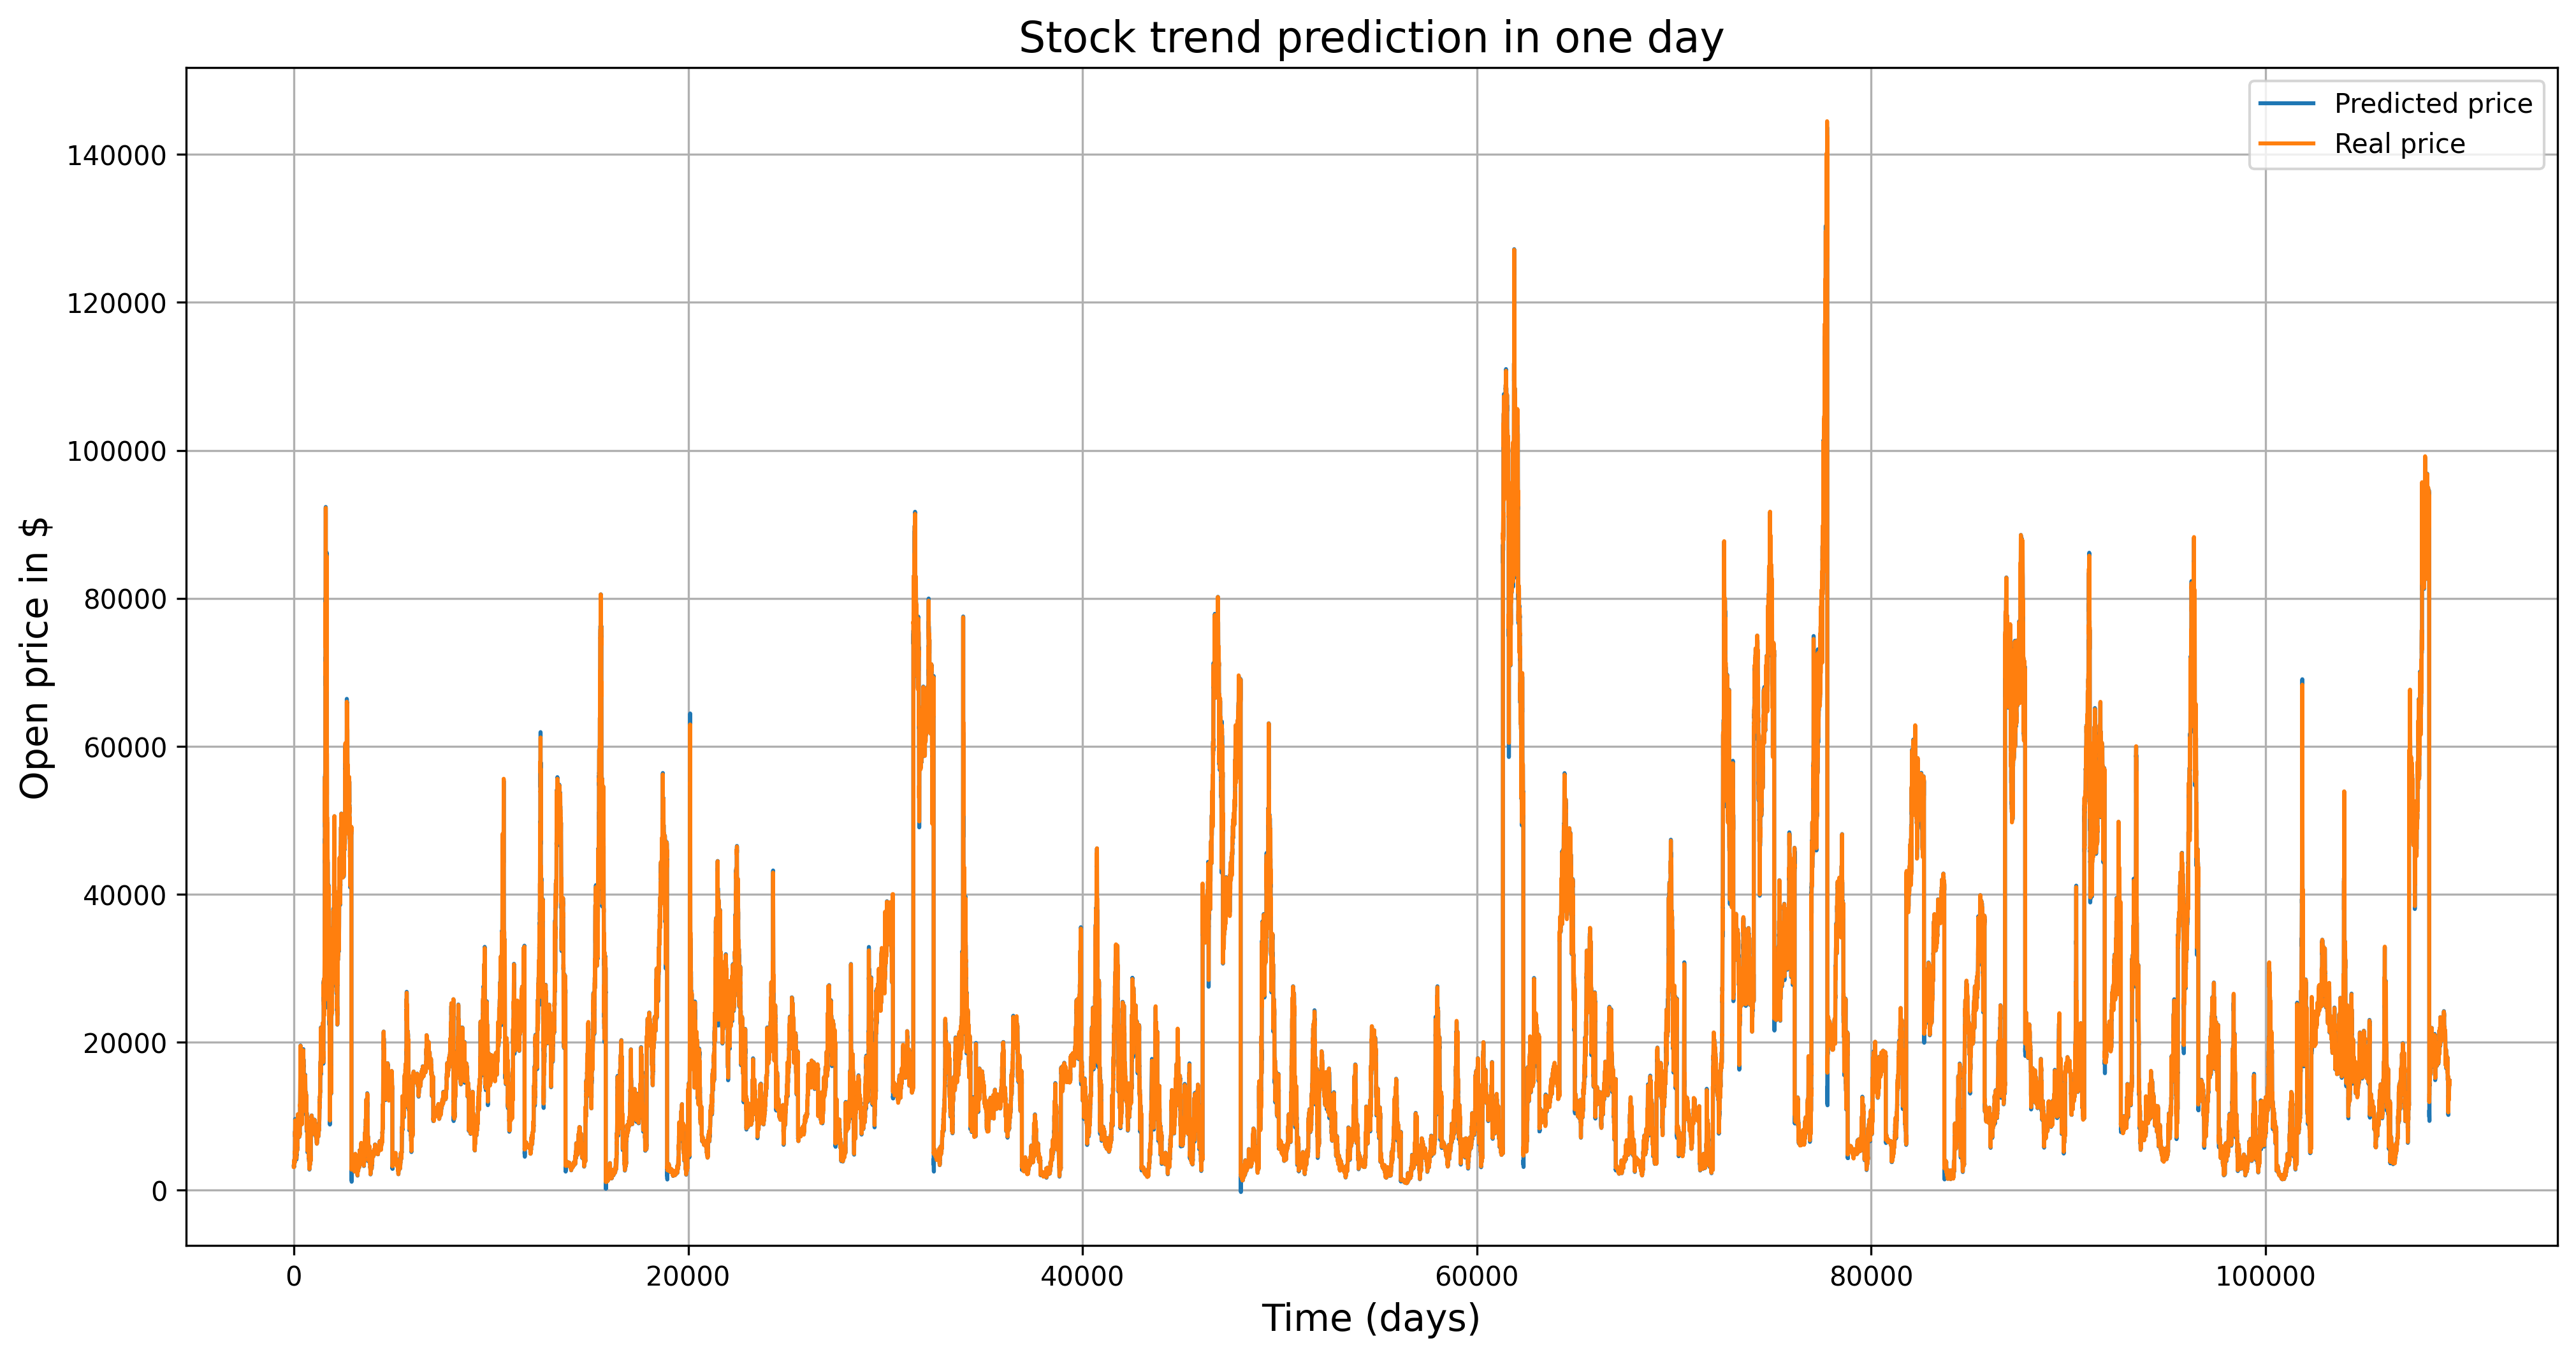

In [ ]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

# Visualize preditec stock price versus real stock price
plt.figure(figsize=(16, 8), dpi=300)
plt.plot(y_pred_denorm, label='Predicted price')
plt.plot(y_test, label='Real price')
plt.title('Stock trend prediction in one day', fontsize=16)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('Open price in $', fontsize=14)
plt.grid() # Add grid
plt.legend() # Add legend
plt.show()